<a href="https://colab.research.google.com/github/AkritiGhosh/Mario-Reinforcement/blob/main/MarioAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teach Reinforcement Learning Agent to play Mario

# Install & Import libraries

For running the mario game - 
1.  Gym - OpenAI Gym
2.  gym_super_mario_bros - version 7.3.0 - The game environment library
3.  nes_py - Nintendo Entertainment System (NES) emulator and OpenAI Gym interface


For displaying the game output on Google Colab - 
1.  pyvirtualdisplay > /dev/null 2>&1
2.  PyVirtualDisplay

For Preprocessing
1.  PyTorch - If unavailable
2.  Stable Baseline3 - Reinforcement learning lib

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install PyVirtualDisplay
!pip install stable-baselines3[extra]

For displaying game output on Google colab - additional updates and installations

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Imports - For Game

In [ ]:
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

Imports - Display output in Google Colab

In [ ]:
from gym.wrappers import Monitor ###
import glob ###
import io ###
import base64 ###
from IPython.display import HTML ###
from pyvirtualdisplay import Display ### 
from IPython import display as ipythondisplay ###

display = Display(visible=0, size=(1400, 900)) ###
display.start() ###

Imports - Preprocessing

In [ ]:
# Convert frame to grayscale
from gym.wrappers import GrayScaleObservation 
# For frame stacking - Combining a couple of frames into 1
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Plotting the stacked frames (optional)
from matplotlib import pyplot as plt

Imports - Reinforcement Learning Algorithm

In [ ]:
# RL Algorithm  - PPO - Proximal Policy Optimization
from stable_baselines3 import PPO
# Saving model
from stable_baselines3.common.callbacks import BaseCallback 
import os

#  Creating the Game environment
 To replicate/reproduce the gaming environment of Mario, the `gym_super_mario_bros`
 is used, and is customized. 


Since, displaying images or videos in Google Colab is different from normal jupyter notbook, therefore additional functions are used to make sure the output is displayed and evaluated properly.

Functions to record/monitor the game/environment output as video(wrap_env()) and show the video into the output(show_env()).

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Creating the environment
1.  Create a environment of SuperMarioBros version 1.
2.  Initially the possible no of moves are 256, which is then reduced to 7 basic steps required to play the game. These 7 steps are given in an array called SIMPLE_MOVEMENT from the SuperMarioBros library. The 7 steps are given in the output of below cell
3.  env.observation_space.shape - Check the dimensions of the frame for the game (optional)

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-v0') # In case of normal/local notebook
# env = wrap_env(gym_super_mario_bros.make('SuperMarioBros-v0'))
print("Initial no of possible moves = ", env.action_space)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
print("Reduced no of possible moves = ", env.action_space)
print(SIMPLE_MOVEMENT)
print("Dimensions of game frame = ", env.observation_space.shape)

Initial no of possible moves =  Discrete(256)
Reduced no of possible moves =  Discrete(7)
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
Dimensions of game frame =  (240, 256, 3)


The following is a simple demonstration of how to play the game. Currently it takes random steps/actions while the game is on.

In normal notebooks, you can observe the game as it being executed, so you can run the code under `while True` loop and stop cell execution when done. 

But in colab, since the simultaneous output is an issue, `show_video()` is used. It will show the video after the code is executed and env closes. Therefore, there must be a closing condition in the loop.

In [ ]:
# Create a flag - restart or not
resume = True
# Loop through each frame in the game
for step in range(1000): 
    # Start the game to begin with 
    if resume: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, resume, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()
show_video() ###

# Data Preprocessing

There are two main preprocessing functions, which are to be used - 
1.  Applying grayscale
2.  Frame Stacking

**Grayscaling** - using GrayScaleObservation() 

The working of the function can be observed by both checking the dimensions of the frame (3 colour channels are reduced to 1) and also visually plot it using `matplotlib.pyplot`


In [ ]:
print("Colored = ", env.observation_space.shape)
env = GrayScaleObservation(env, keep_dim = True) #keep_dim - preserve the shape of frame as 3d -(240,256,1) - instead of 2d - (240,256)
print("Grayed = ", env.observation_space.shape)

Colored =  (240, 256, 3)
Grayed =  (240, 256, 1)


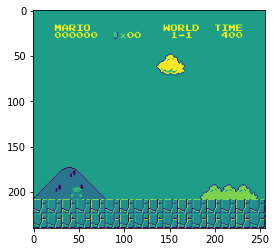

In [ ]:
env.reset()
state, reward, resume, info = env.step(env.action_space.sample())
plt.imshow(state.reshape(240,256))

**Frame Stacking** - Stack 4 (or more) frames together so that a group of frames can be used as input for AI model. 

This enables the model to observe not only the position of agent, but also the movement, direction etc

In [ ]:
# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
print(env.observation_space.shape)
# Stack the frames
env= VecFrameStack(env, 4, channels_order='last')
print(env.observation_space.shape)

(240, 256, 1)
(240, 256, 4)


# Train the Reinforcement Learning Model

In [ ]:
# Custom function for callbacks - auto saving the trained model, after a particular no of training is done
class TrainAndLoggingCallback(BaseCallback):

# check_freq - frequency of saving model - if parameter = 100, every 100th model is saved
# save_path - path to save file
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
# Location for saving callback models and log directory. 
# In colab, after saving, you also need to download the model
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
# Initializing the callback variable, to be used while training
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [ ]:
# AI model created
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 
# Training model
model.learn(total_timesteps=50000, callback=callback)


Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_4


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 134 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 72            |
|    iterations           | 2             |
|    time_elapsed         | 14            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.4810433e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.000649      |
|    learning_rate        | 1e-06         |
|    loss                 | 202           |
|    n_updates            | 10            |
|    policy_gradient_loss | -3.57e-05     |
|    value_loss           | 461           |
-------------------------------------------
-----

# Testing Model on environment

Here the trained model is used on a new environment, which is preprocessed the same way as the training environment was. 
Testing can be done on the previous training environment as well.

In [ ]:
envm = wrap_env(gym_super_mario_bros.make('SuperMarioBros-v0'))
envm = JoypadSpace(envm, SIMPLE_MOVEMENT)
envm = GrayScaleObservation(envm, keep_dim = True)
envm = DummyVecEnv([lambda: envm])
envm= VecFrameStack(envm, 4, channels_order='last')
state = envm.reset()

Saved Model is (uploaded to colab and) loaded into variable model. If testing right after training, you can use the last trained model as well, without loading saved model.

In [ ]:
model = PPO.load('model_98_105')

Environment is run the same way as ahown above. Only this time, model is predicting the action for every frame.

In [ ]:
state = envm.reset()
for step in range(100000): 
    action, _ = model.predict(state)
    state, reward, resume, info = envm.step(action)
    envm.render()
# Close the game
envm.close()
show_video() ###

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256
